<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Tarea 4:  Detección Automática de Cultivos en Egipto. </center></h2>


In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import ee, geemap
import contextily as ctx
from shapely import Polygon
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
ee.Authenticate()
ee.Initialize()

In [3]:
def mask_s2_clouds(image):
  qa = image.select('QA60')
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
  return image.updateMask(mask).divide(10000)

#### 3.1. Lea y grafique los datos de entrenamiento entregados 

C:\Users\Panorámica\AppData\Local\Temp\ipykernel_8020\1121632383.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centros.geometry=data.centroid
c:\Users\Panorámica\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  object.__setattr__(self, attr, val)


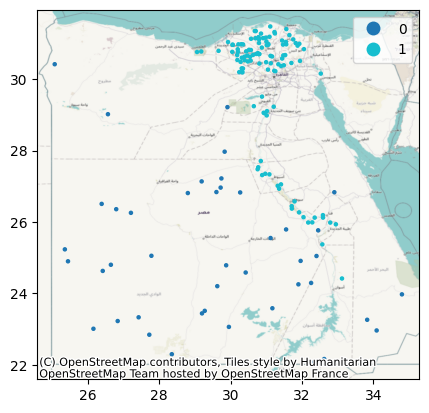

In [4]:
data = gpd.read_file('crop_training_egypt.geojson')

centros=gpd.GeoDataFrame()
centros.geometry=data.centroid
centros['class']=data['class']

fig,ax=plt.subplots(1,1)
centros.plot(column = 'class', ax=ax,categorical=True,legend=True,markersize=5)
ctx.add_basemap(ax, crs=data.crs);

#### Parte 3.1 - 3.6

Como el aoi que incluye todos los centros es muy grande, he decidido hacer otro procedimiento para llegar a lo mismo. Me fijé que hay áreas muy grandes que no utilizaría si es que saco la imagen grande que incluye todos los centros, por esto, opté a sacar las imagenes individualmente de cada polígono testeado, y posteriormente calcular cada promedio independientemente. He hecho todo con estas funciones:

In [5]:
def bandas_medio(pol):
    xx, yy = pol.exterior.coords.xy
    z = []
    for i in range(len(xx)):
        z.append([xx[i], yy[i]])

    aoi = ee.Geometry.Polygon(z)

    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(aoi)
    col_2019 = collection.filter(ee.Filter.calendarRange(2019, 2019, 'year'))
    im_2019 = col_2019.aggregate_array('system:id').getInfo()

    sin_nubes = []
    for imagen in im_2019:
        im = ee.Image(imagen)
        im.resample('bilinear').reproject(crs=4326, scale=20)
        sin_nubes.append(mask_s2_clouds(im))

    col = ee.ImageCollection(sin_nubes)

    col_med = col.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B11', 'B12'])
    med = col_med.reduce(ee.Reducer.geometricMedian(8))
    med = med.clip(aoi)

    prom = med.reduceRegion(reducer= ee.Reducer.mean(), geometry= aoi, scale= 30, maxPixels= 1e9)
    inf = prom.getInfo()

    vals = [inf[i] for i in inf.keys()]

    return vals

def get_indices(pol):
    xx, yy = pol.exterior.coords.xy
    z = []
    for i in range(len(xx)):
        z.append([xx[i], yy[i]])

    aoi = ee.Geometry.Polygon(z)

    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(aoi)
    col_2019 = collection.filter(ee.Filter.calendarRange(2019, 2019, 'year'))
    im_2019 = col_2019.aggregate_array('system:id').getInfo()

    sin_nubes = []
    for imagen in im_2019:
        im = ee.Image(imagen)
        im.resample('bilinear').reproject(crs=4326, scale=20)
        sin_nubes.append(mask_s2_clouds(im))

    indices = []
    for imagen in sin_nubes:
        ndvi = imagen.normalizedDifference(['B8', 'B4']).rename('NDVI')
        mndwi = imagen.normalizedDifference(['B3', 'B11']).rename('MNDWI')
        evi = imagen.expression( '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', 
                                {'NIR': imagen.select('B8'), 'RED': imagen.select('B4'), 'BLUE': imagen.select('B2')
                                                                                            }).rename("EVI")
        imagen = imagen.addBands(evi)
        lai = imagen.expression(
            '(3.618*EVI - 0.118)', {
                'EVI': imagen.select('EVI')
            }).rename("LAI")
        imagen = imagen.addBands(lai)
        imagen = imagen.addBands(mndwi)
        indices.append(imagen.addBands(ndvi))

    col = ee.ImageCollection(indices)

    col_med = col.select(['NDVI', 'MNDWI', 'LAI'])
    med = col_med.reduce(ee.Reducer.geometricMedian(3))
    med = med.clip(aoi)

    prom = med.reduceRegion(reducer= ee.Reducer.mean(), geometry= aoi, scale= 30, maxPixels= 1e9)
    inf = prom.getInfo()

    vals = [inf[i] for i in inf.keys()]

    return vals

In [6]:
geometrias = data['geometry']

In [7]:
valores = {}
for geom in geometrias:
    valores[geom] = bandas_medio(geom)

b2 = data['geometry'].apply(lambda x: valores[x][0])
b3 = data['geometry'].apply(lambda x: valores[x][1])
b4 = data['geometry'].apply(lambda x: valores[x][2])
b5 = data['geometry'].apply(lambda x: valores[x][3])
b6 = data['geometry'].apply(lambda x: valores[x][4])
b7 = data['geometry'].apply(lambda x: valores[x][5])
b11 = data['geometry'].apply(lambda x: valores[x][6])
b12 = data['geometry'].apply(lambda x: valores[x][7])

data['B2'] = b2
data['B3'] = b3
data['B4'] = b4
data['B5'] = b5
data['B6'] = b6
data['B7'] = b7
data['B11'] = b11
data['B12'] = b12

In [8]:
valores_indices = {}
for geom in geometrias:
    valores_indices[geom] = get_indices(geom)

ndvi = data['geometry'].apply(lambda x: valores_indices[x][0])
mndwi = data['geometry'].apply(lambda x: valores_indices[x][1])
lai = data['geometry'].apply(lambda x: valores_indices[x][2])

data['NDVI'] = ndvi
data['MNDWI'] = mndwi
data['LAI'] = lai

In [9]:
#Datos extendidos
data.head()

,class,geometry,B2,B3,B4,B5,B6,B7,B11,B12,NDVI,MNDWI,LAI
0,0,"POLYGON ((26.19189 22.06193, 26.19230 22.06193...",0.173609,0.286497,0.461008,0.508861,0.523908,0.541593,0.731422,0.673776,0.092183,-0.437037,0.162695
1,0,"POLYGON ((32.24947 22.07338, 32.24989 22.07338...",0.127006,0.219261,0.395781,0.441419,0.452528,0.461725,0.616041,0.580087,0.080311,-0.474509,0.097090
2,0,"POLYGON ((32.62301 22.15862, 32.62342 22.15862...",0.091457,0.129560,0.177801,0.192912,0.196344,0.207204,0.338254,0.293814,0.083777,-0.460906,0.058204
3,0,"POLYGON ((28.35345 22.29337, 28.35386 22.29337...",0.195398,0.318083,0.470082,0.516055,0.527211,0.544657,0.708032,0.665026,0.078040,-0.379924,0.130065
4,0,"POLYGON ((27.72311 22.83994, 27.72352 22.83994...",0.194079,0.309972,0.456805,0.504289,0.522577,0.543961,0.752600,0.694967,0.091091,-0.418159,0.175236


In [28]:
pol = geometrias[100]

xx, yy = pol.exterior.coords.xy
z = []
for i in range(len(xx)):
    z.append([xx[i], yy[i]])

aoi = ee.Geometry.Polygon(z)

collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(aoi)
col_2019 = collection.filter(ee.Filter.calendarRange(2019, 2019, 'year'))
im_2019 = col_2019.aggregate_array('system:id').getInfo()

sin_nubes = []
for imagen in im_2019:
    im = ee.Image(imagen)
    im.resample('bilinear').reproject(crs=4326, scale=20)
    sin_nubes.append(mask_s2_clouds(im))

col = ee.ImageCollection(sin_nubes)

col_med = col.select(['B2', 'B3', 'B4'])
med = col_med.reduce(ee.Reducer.geometricMedian(3))
med = med.clip(aoi)

In [32]:
#Visualización
Map = geemap.Map(zoom=13)

vis_params = {"min": 0, "max": 0.3, "bands": ["geometric_median_2", 'geometric_median_1', 'geometric_median_0']}

Map.addLayer(med, vis_params ,name='Imagen')
Map.centerObject(aoi)
Map.addLayer(aoi,name='aoi',shown=True, opacity = 0.4)

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

#### 3.7 Entrene un modelo de clasificación binaria (por ejemplo, kNN o RandomForest), justificando su selección de hiperparámetros.

In [10]:
y = data['class']
X = data.drop(['class', 'geometry'], axis = 1)

#Datos entrenamiento/ testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109, stratify=y)

In [11]:
#Entrenamiento modelo
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

Para seleccionar estos parámetros, fui probando a mano y decidí que estos demoraban poco en el entreno y presentan buenos resultados presentados abajo.

#### 3.8 Evalúe el rendimiento del clasificador utilizando métricas como accuracy, F1 y ROC.

In [12]:
pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred)
print("Precision:", precision)

recall = recall_score(y_test, pred)
print("Recall:", recall)

f1 = f1_score(y_test, pred)
print("F1-Score:", f1)

Accuracy: 0.96875
Precision: 0.9583333333333334
Recall: 1.0
F1-Score: 0.9787234042553191


#### 3.9 Aplique el clasificador entrenado en el punto anterio para generar nuevas predicciones en las ubicaciones de prueba definidas más abajo (`testing_locations`)

In [13]:
testing_locations = {
    '1': (24.4780, 33.0457),
    '2': (22.7712, 28.5223),
    '3': (30.3971, 30.7996),
    '4': (31.1751, 31.2221),
}

In [14]:
def df_test_location(num):
    loc = testing_locations[str(num)]

    dis = 0.01
    minx = loc[1] - dis
    maxx = loc[1] + dis
    miny = loc[0] - dis
    maxy = loc[0] + dis

    xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]
    aoi = ee.Geometry.Polygon(xy)

    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(aoi)
    col_2019 = collection.filter(ee.Filter.calendarRange(2019, 2019, 'year'))
    im_2019 = col_2019.aggregate_array('system:id').getInfo()

    sin_nubes = []
    for imagen in im_2019:
        im = ee.Image(imagen)
        im.resample('bilinear').reproject(crs=4326, scale=20)
        sin_nubes.append(mask_s2_clouds(im))

    indices = []
    for imagen in sin_nubes:
        ndvi = imagen.normalizedDifference(['B8', 'B4']).rename('NDVI')
        mndwi = imagen.normalizedDifference(['B3', 'B11']).rename('MNDWI')
        evi = imagen.expression( '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', 
                                {'NIR': imagen.select('B8'), 'RED': imagen.select('B4'), 'BLUE': imagen.select('B2')
                                                                                            }).rename("EVI")
        imagen = imagen.addBands(evi)
        lai = imagen.expression(
            '(3.618*EVI - 0.118)', {
                'EVI': imagen.select('EVI')
            }).rename("LAI")
        imagen = imagen.addBands(lai)
        imagen = imagen.addBands(mndwi)
        indices.append(imagen.addBands(ndvi))
    
    col = ee.ImageCollection(indices)
    col_med = col.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B11', 'B12', 'LAI', 'NDVI', 'MNDWI'])
    med = col_med.reduce(ee.Reducer.geometricMedian(11))
    med = med.clip(aoi)
    
    snic = ee.Algorithms.Image.Segmentation.SNIC(image=med, size=30, compactness=0.1, connectivity=8)

    snic_clusters = snic.select('clusters')
    fc = snic_clusters.reduceToVectors(geometry=aoi,eightConnected=True,scale=10)

    gdf = geemap.ee_to_gdf(fc)
    gdf=gdf.set_crs(crs=4326)

    geometrias_1 = gdf['geometry']
    valores_1 = {}
    for geom in geometrias_1:
        valores_1[geom] = bandas_medio(geom)

    b2 = gdf['geometry'].apply(lambda x: valores_1[x][0])
    b3 = gdf['geometry'].apply(lambda x: valores_1[x][1])
    b4 = gdf['geometry'].apply(lambda x: valores_1[x][2])
    b5 = gdf['geometry'].apply(lambda x: valores_1[x][3])
    b6 = gdf['geometry'].apply(lambda x: valores_1[x][4])
    b7 = gdf['geometry'].apply(lambda x: valores_1[x][5])
    b11 = gdf['geometry'].apply(lambda x: valores_1[x][6])
    b12 = gdf['geometry'].apply(lambda x: valores_1[x][7])

    gdf['B2'] = b2
    gdf['B3'] = b3
    gdf['B4'] = b4
    gdf['B5'] = b5
    gdf['B6'] = b6
    gdf['B7'] = b7
    gdf['B11'] = b11
    gdf['B12'] = b12

    valores_1_indices = {}
    for geom in geometrias_1:
        valores_1_indices[geom] = bandas_medio(geom)

    ndvi = gdf['geometry'].apply(lambda x: valores_1_indices[x][0])
    mndwi = gdf['geometry'].apply(lambda x: valores_1_indices[x][1])
    lai = gdf['geometry'].apply(lambda x: valores_1_indices[x][2])

    gdf['NDVI'] = ndvi
    gdf['MNDWI'] = mndwi
    gdf['LAI'] = lai

    return gdf

In [16]:
#Data frames de cada locación
gdf_1 = df_test_location(1)
gdf_2 = df_test_location(2)
gdf_3 = df_test_location(3)
gdf_4 = df_test_location(4)

<Axes: >

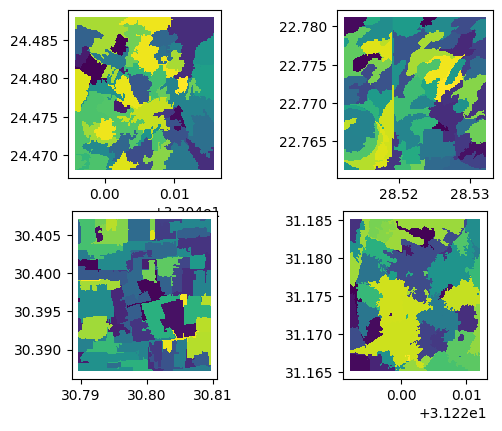

In [34]:
#Gráfica de clusters
fig, axes = plt.subplots(nrows=2, ncols=2)

gdf_1.plot(column = 'label', ax=axes[0,0])
gdf_2.plot(column = 'label', ax=axes[0,1])
gdf_3.plot(column = 'label', ax=axes[1,0])
gdf_4.plot(column = 'label', ax=axes[1,1])

In [17]:
for gdf in [gdf_1, gdf_2, gdf_3, gdf_4]:
    X = gdf.drop(['geometry', 'count', 'label'], axis = 1)
    gdf['class'] = clf.predict(X)

<Axes: >

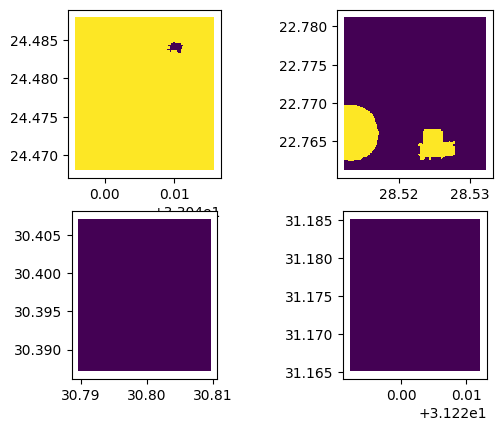

In [35]:
#Gráfica de clusters
fig, axes = plt.subplots(nrows=2, ncols=2)

gdf_1.plot(column = 'class', ax=axes[0,0])
gdf_2.plot(column = 'class', ax=axes[0,1])
gdf_3.plot(column = 'class', ax=axes[1,0])
gdf_4.plot(column = 'class', ax=axes[1,1])

Nota: en estas figuras, el morado representa clase 1 y el amarillo clase 0 (potencialmente puede que estos colores se intercambien eso si). En 2 de las 4 locaciones se ve una tendencia total. En las restantes 2 se ven tendencias evidentes tambien.